# Benchmark Tutorial

In [1]:
# If you are executing this notebook at a location different than root, you need to add it to
# the path.
import sys
sys.path.insert(0,'../../')

In [2]:
import keras
import tensorflow as tf
from functools import partial

Using TensorFlow backend.


In [3]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : /home/efernand/repos/Summer_Internship_2019/Examples/JupyterNotebooks
Directory name is : JupyterNotebooks


In [4]:
# OpenDenoising modules
from OpenDenoising import data
from OpenDenoising import model
from OpenDenoising import evaluation
from OpenDenoising import Benchmark

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
keras.backend.set_session(session)

## Table of Contents
---

* [Metrics](#metrics)
* [Visualizations](#visualizations)
* [ModelEvaluator](#model-evaluator)

## Metrics <a class="anchor" id="metrics"></a>
---

The metrics sub-module is composed by wrapper functions to metrics used to assess image restoration quality, such as __MSE__, __SSIM__ and __PSNR__. These functions simply wrap [skimage.measure](https://scikit-image.org/docs/dev/api/skimage.measure.html) functions, so that they work with 4D arrays.

__MSE:__ The [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) metric is a common metric used to calculate the distance between two images in a euclidean space. If measures the mean per-pixel deviation between $y_{true}$ and $y_{pred}$,

\begin{align}
    RMSE = \dfrac{1}{N\times H\times W\times C}\sum_{n=1}^{N}\sum_{i=1}^{H}\sum_{j=1}^{W}\sum_{k=1}^{C}(y_{true}(n, i, j, k)-y_{pred}(n, i, j, k))^{2}
\end{align}

__SSIM:__ The [Structural Similarity Index](https://en.wikipedia.org/wiki/Structural_similarity) is a metric that evaluates the perceived quality of a given image, with respect to a reference image. Let $x$ and $y$ be image patches, the SSIM between them is,

\begin{align}
    SSIM(x, y) = \dfrac{(2\mu_{x}\mu_{y}+C_{1})(2\sigma_{xy}+C_{2})}{(\mu_{x}^{2}+\mu_{y}^{2}+C_{1})(\sigma_{x}^{2}+\sigma_{y}^{2}+C_{2})}
\end{align}

where

* $\mu_{x}$, $\mu_{y}$ are respectively the mean of pixels in each patch.
* $\sigma_{x}$, $\sigma_{y}$ are respectively the variance of pixels in each patch.
* $\sigma_{xy}$ is the covariance between patches $x$ and $y$.
* $c_{1} = 0.01$, $c_{2} = 0.03$

The image overall SSIM, a scalar value, is taken as the mean value of SSIM on each patch.

__PSNR:__ The [Peak Signal to Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) is metric used for measuring noise present on signals. Its computation is based on the MSE metric,

\begin{align}
    PSNR(y_{true}, y_{pred}) = 10log_{10}\biggr(\dfrac{max(y_{true})}{MSE(y_{true}, y_{pred})}\biggr)
\end{align}

where $max(y_{true})$ corresponds to the maximum pixel value on $y_{true}$.

### Visualizations <a class="anchor" id="visualizations"></a>
---

Visualizations are functions that use the Benchmark evaluation results to display information graphically. As it will be explained on the [Benchmarking Module](#benchmarking-module), the results of a evaluation session are stored in two .csv files,

* (\$BENCHMARK_NAME)_GeneralResults.csv: stores aggregates of metrics, such as mean and variance.
* (\$BENCHMARK_NAME)_Values.csv: stores the metrics computed on each image of each dataset.

Visualizations rely on Pandas and Seaborn to display these informations, hence, your function should agree with the following convention,

```Python
def my_visualization(csv_path, **kwargs):
    # Steps to generate your plot
```

### ModelEvaluator <a class="anchor" id="evaluators"></a>
---

The evaluator class is responsable for evaluating a model on a given dataset. It holds all the information about the inference session, such as metrics. Apart from training models on datasets, this class is the main responsable for the Benchmark purpose: the fair comparison of denoising algorithms.

The comparison between denoising algorithms is established by specifying the following,

* A denoising algorithm, which is wrapped by Denoiser classes.
* A dataset, which is generated using DatasetGenerator classes.
* A set of metrics, each of which computing a scalar allowing to compare different algorithms.
* A set of visualizations, which display the later informations graphically.

#### Specifying datasets

In [6]:
# Downloading testsets
try:
    data.download_dncnn_testsets(output_dir="../../tmp/TestSets", testset="BSD68")
except FileExistsError as err:
    pass

try:
    data.download_dncnn_testsets(output_dir="../../tmp/TestSets", testset="Set12")
except FileExistsError as err:
    pass

In [7]:
# BSD Dataset
BSD68 = data.DatasetFactory.create(path="../../tmp/TestSets/BSD68/",
                                   batch_size=1,
                                   n_channels=1,
                                   noise_config={data.utils.gaussian_noise: [25]},
                                   name="BSD68")
# Set12 Dataset
Set12 = data.DatasetFactory.create(path="../../tmp/TestSets/Set12/",
                                   batch_size=1,
                                   n_channels=1,
                                   noise_config={data.utils.gaussian_noise: [25]},
                                   name="Set12")
datasets = [BSD68, Set12]

#### Specifying models

__Deep Learning models__

In "./Additional Files", you have at your disposal various pre-trained models. To load them, you only need to specify the path to the file containing their architecture/weights. For more details about how the model module works, you can look the Model module tutorial.

Bellow, we charge each model using the respective wrapper class for its framework.

In [8]:
# Keras rednet30
keras_rednet30 = model.KerasModel(model_name="Keras_Rednet30", logdir="../../training_logs/Keras")
keras_rednet30.charge_model(model_path="./Additional Files/Keras Models/rednet30.hdf5")

# Keras rednet20
keras_rednet20 = model.KerasModel(model_name="Keras_Rednet20", logdir="../../training_logs/Keras")
keras_rednet20.charge_model(model_path="./Additional Files/Keras Models/rednet20.hdf5")

# Keras rednet10
keras_rednet10 = model.KerasModel(model_name="Keras_Rednet10", logdir="../../training_logs/Keras")
keras_rednet10.charge_model(model_path="./Additional Files/Keras Models/rednet10.hdf5")

# Onnx dncnn from Matlab
onnx_dncnn = model.OnnxModel(model_name="Onnx_DnCNN")
onnx_dncnn.charge_model(model_path="./Additional Files/Onnx Models/dncnn.onnx")

/home/efernand/anaconda3/envs/OpenDenoisingEnv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__Filtering models__

The specification of filtering models is made the same way. Since these kinds of model do not need to be trained, you only need to specify the function that will perform the denoising. Bellow, we specify BM3D implemented on Python through Matlab's engine.

__Note__ If you have not installed Matlab support, or have not installed BM3D library from [the author's website](http://www.cs.tut.fi/~foi/GCF-BM3D/), comment the next block.

In [9]:
# BM3D from Matlab
bm3d_filter = model.FilteringModel(model_name="BM3D_filter")
bm3d_filter.charge_model(model_function=model.filtering.BM3D, sigma=25.0, profile="np")

In [10]:
# List of models
# Note: comment/uncomment the following lines according to if you have specified or not bm3d_filter.
# List with BM3D:
models = [bm3d_filter, onnx_dncnn, keras_rednet10, keras_rednet20, keras_rednet30]
# List without BM3D:
# models = [onnx_dncnn, keras_rednet10, keras_rednet20, keras_rednet30]

In [11]:
models

[Filtering model name: BM3D_filter,
 Model name: Onnx_DnCNN, Framework: Onnx,
 Model name: Keras_Rednet10, Framework: Keras,
 Model name: Keras_Rednet20, Framework: Keras,
 Model name: Keras_Rednet30, Framework: Keras]

#### Specifying metrics

As already explained, a metric is a function computed using the ground-truth $y_{true}$ and the network's prediction $y_{pred}$. Bellow, we use three metrics in our evaluations, that were already coded in the benchmarking module. 

In [12]:
mse_metric = evaluation.Metric(name="MSE", np_metric=evaluation.skimage_mse)
ssim_metric = evaluation.Metric(name="SSIM", np_metric=evaluation.skimage_ssim)
psnr_metric = evaluation.Metric(name="PSNR", np_metric=evaluation.skimage_psnr)

metrics = [mse_metric, psnr_metric, ssim_metric]

__Specifying Visualizations__

In [13]:
boxplot_PSNR = evaluation.Visualisation(func=partial(evaluation.boxplot, metric="PSNR"),
                                        name="Boxplot_PSNR")

boxplot_SSIM = evaluation.Visualisation(func=partial(evaluation.boxplot, metric="SSIM"),
                                        name="Boxplot_SSIM")

boxplot_MSE = evaluation.Visualisation(func=partial(evaluation.boxplot, metric="MSE"),
                                        name="Boxplot_MSE")



visualisations = [boxplot_PSNR, boxplot_SSIM, boxplot_MSE]

__Create ModelEvaluator object__

To evaluate your models on the desired datasets, you need to create an ModelEvaluator. Having a list of __metrics__, __datasets__, __models__ and __visualizations__, you can register each of them by using register functions, as shown bellow,

[Benchmark] Evaluating model BM3D_filter on dataset BSD68
[Benchmark] Evaluating model Onnx_DnCNN on dataset BSD68
[Benchmark] Evaluating model Keras_Rednet10 on dataset BSD68
[Benchmark] Evaluating model Keras_Rednet20 on dataset BSD68
[Benchmark] Evaluating model Keras_Rednet30 on dataset BSD68
[Benchmark] Evaluating model BM3D_filter on dataset Set12
[Benchmark] Evaluating model Onnx_DnCNN on dataset Set12
[Benchmark] Evaluating model Keras_Rednet10 on dataset Set12
[Benchmark] Evaluating model Keras_Rednet20 on dataset Set12
[Benchmark] Evaluating model Keras_Rednet30 on dataset Set12


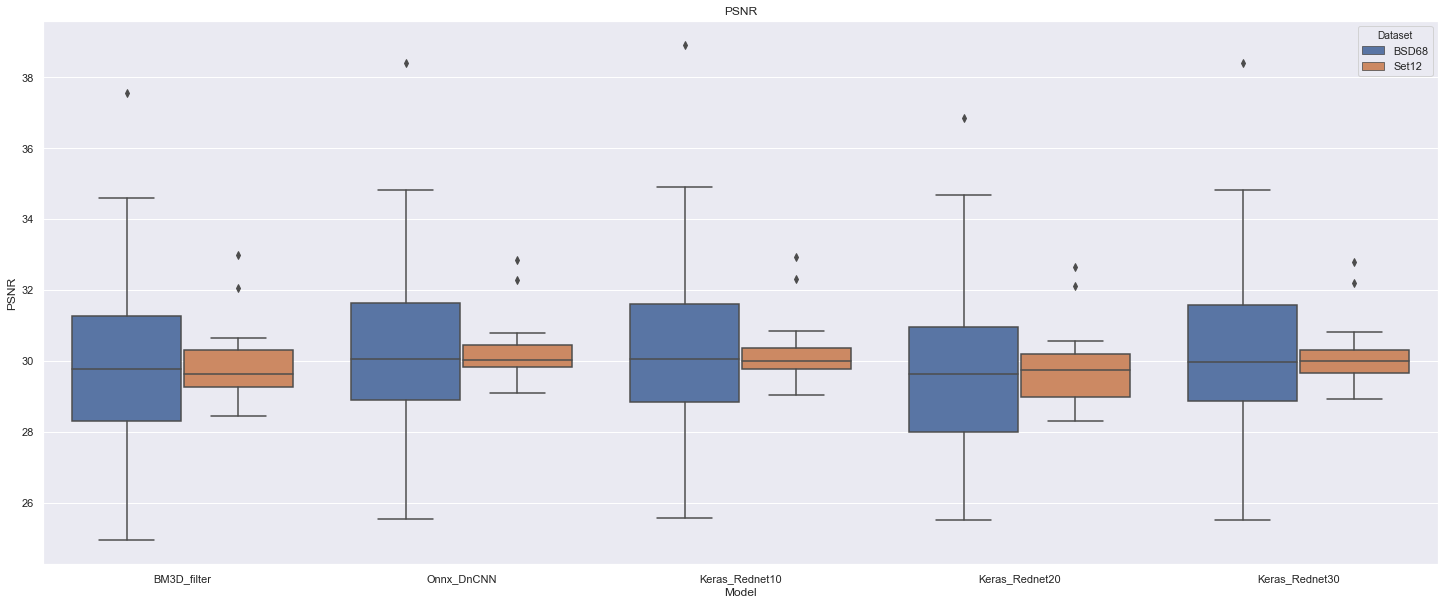

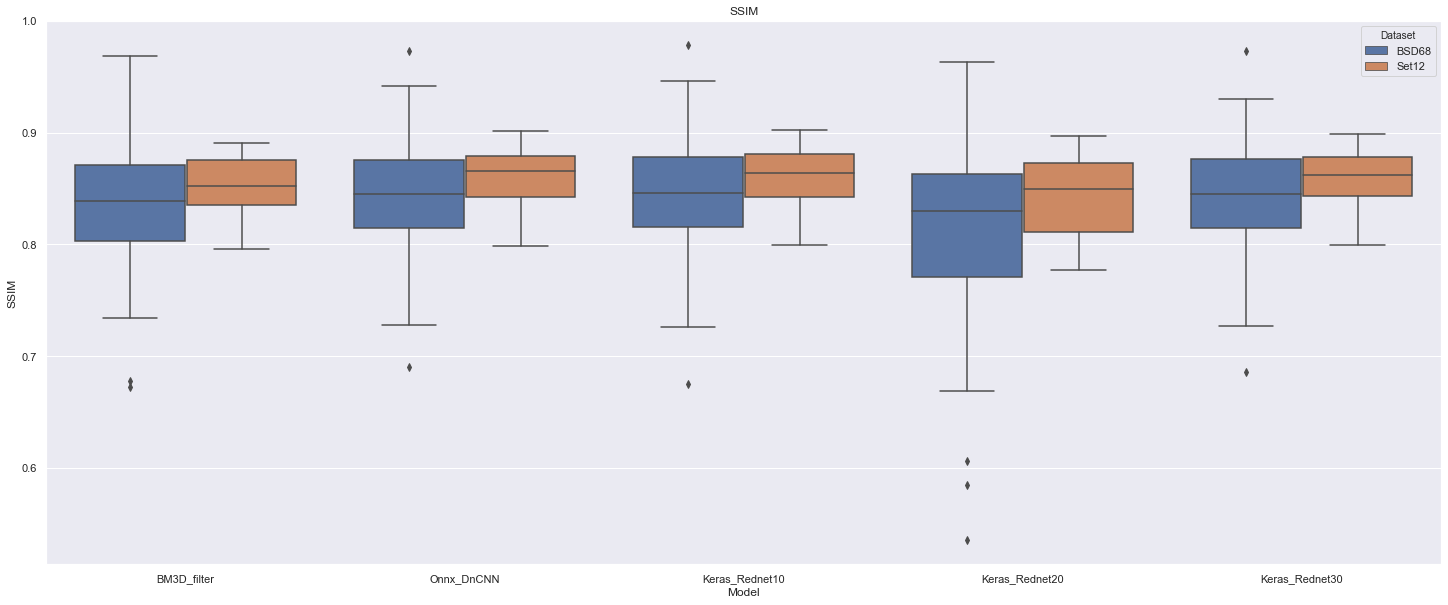

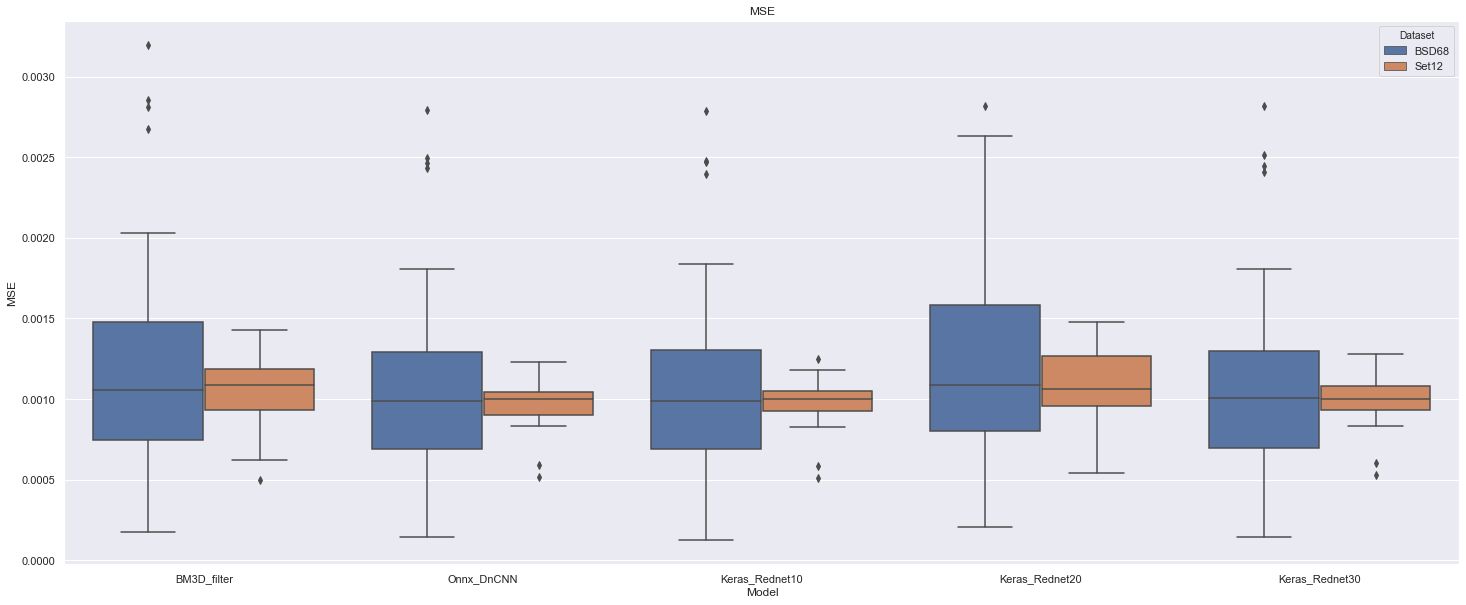

In [14]:
benchmark = Benchmark(name="BSD68_Test12")

# Register metrics
benchmark.register(metrics)
# Register datasets
benchmark.register(datasets)
# Register models
benchmark.register(models)
# Register visualisations
benchmark.register(visualisations)

benchmark.evaluate()

In [15]:
# Run this cell to free up the memory
import gc

for mdl in models:
    mdl = None
models = None
for dataset in datasets:
    dataset = None
datasets = None
for metric in metrics:
    metric = None
metrics = None
for visualisation in visualisations:
    visualisation = None
visualisations = None
benchmark = None

# Resets constructed tensorflow graph.
tf.reset_default_graph()

# Runs garbage collector
gc.collect()

2158608

In [16]:
# Run this cell to exclude downloaded files
import shutil

shutil.rmtree("../../tmp/TestSets/")